#### The program in this Jupyter Notebook is based on the work of Raissi et al.(2019). For the full citation look at the reference section below.

## Diffusion Equation

Consider the following PDE
$$
\frac{\partial \: u(x,t)}{\partial t}  =
\frac{\partial^2 \: u(x,t)}{\partial x^2}  - u(x,t), \quad  x \in (0,1), \quad t>0
$$

<br></br>
Subject to the following boundary and initial condtions
<br></br>

$$
u(0,t) = u(1,t) = 0,\quad t \geq  0\\
u(x,0) = \sin(\pi x),\quad  x \in [0,1]
$$


The Exact solution is
$$u(x,t) = \sin(\pi x) e^{-(\pi^2+1)t}$$


In [21]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, exp

## plot the exact solution

In [55]:
def exact_sol(x, t):
  return torch.sin(pi * x) * np.exp( -(pi**2 + 1) * t )

def init_cond(x):
  return torch.sin(pi * x)

In [57]:
x_0, x_f = 0.0, 1.0
t_0, t_f = 0.0, 1.0

x_axis = torch.linspace(0, 1, 200)
t_axis = torch.linspace(0, 1, 200)
x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing="xy")

u_exact = exact_sol(x_grid, t_grid)

In [58]:
def plot_solution(x_grid, t_grid, u, title=""):
  fig = plt.figure(figsize=(5,4), tight_layout=True, dpi=100)
  ax = fig.add_subplot(111)
  colormap = ax.pcolormesh(x_grid, t_grid, u)
  ax.set_title(title)
  ax.set_xlabel("x")
  ax.set_ylabel("t")
  fig.colorbar(colormap)
  plt.show()

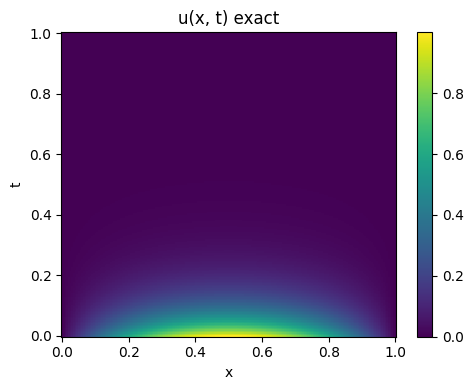

In [59]:
plot_solution(x_grid, t_grid, u_exact, title="u(x, t) exact")

## Build a Neural Network

In [12]:
# Define the neural network
class FCN(nn.Module):
  def __init__(self, n_input, n_output, n_hidden_layers, n_hidden_units):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    self.n_hidden_layers = n_hidden_layers
    self.n_hidden_units = n_hidden_units

    #Define the input layer
    self.linear_layer = nn.Linear(n_input, n_hidden_units)
    torch.nn.init.xavier_uniform_(self.linear_layer.weight)
    self.input_layer = nn.Sequential(
        self.linear_layer,
        nn.Tanh()
    )

    #Define the hidden layers
    self.hidden_layers = []
    for _ in range(n_hidden_layers - 1):
      self.linear_layer = nn.Linear(n_hidden_units, n_hidden_units)
      torch.nn.init.xavier_uniform_(self.linear_layer.weight)
      self.hidden_layers.append( self.linear_layer )
      self.hidden_layers.append ( nn.Tanh() )

    self.hidden_layers = nn.Sequential(*self.hidden_layers)

    #Define the output layer
    self.linear_layer = nn.Linear(n_hidden_units, n_output)
    torch.nn.init.xavier_uniform_(self.linear_layer.weight)
    self.output_layer = nn.Sequential( self.linear_layer )

  def forward(self, x):
    output = self.input_layer(x)
    output = self.hidden_layers(output)
    output = self.output_layer(output)
    return output

# Discrete time Physics Informed Neural Network

We can write the diffusion equation equation as the following

$$
\frac{\partial u(x,t)}{\partial t} = g[u]
$$

Where $g[\cdot]$ is a differential operator such that

$$
g[u] = \frac{\partial^2 \: u(x,t)}{\partial x^2}  - u(x,t)
$$

Next, we apply Runge-Kutta method with $q$ stages to the PDE[2].

$$
u_{n+c_i} = u_n + \Delta t \sum_{j=1}^{q} a_{ij} \, g[u_{n+c_j}] \quad \text{for} \; i = 1, 2, \dots, q
$$

$$
u_{n+1} = u_n + \Delta t \sum_{j=1}^{q} b_j \, g[u_{n+c_j}]
$$

Where $\: u_{n+c_j} = u(t+c_j \Delta t, x)$ and
$$
g[u_{n+c_j}] =  \frac{\partial^2 \: u_{n+c_j}}{\partial x^2}  - u_{n+c_j}
$$

**Note:** We will refer to $u_{n+c_j}$ as the intermediate solutions.

Now, we rearrange the discretized equations, so that all the unknown variables on one side and the known variables one the other.

$$
u_{n+c_i} - \Delta t \sum_{j=1}^{q} a_{ij} \, g[u_{n+c_j}] = u_n \quad \text{for}  \; i = 1, 2, \dots, q
$$

$$
u_{n+1} - \Delta t \sum_{j=1}^{q} b_j \, g[u_{n+c_j}] =  u_n
$$

The neural network will predict the intermediate solutions, $u_{n+c_i}$, and the solution at the next step in time, $u_{n+1}$. Therefore, the last layer will have $q+1$ neurons and we notice that the number of neurons increase linearly with the number of stages.[1]

If we have the exact values of $u_{n+c_j}$  and $u_{n+1}$ then we can compute the previous value $u_n$, but since these values will be arbitrary after initializing the neural network, then the previous will be different from the exact $u_n$ (which is known to us)[1].

$$
u_{n+c_i} - \Delta t \sum_{j=1}^{q} a_{ij} \, g[u_{n+c_j}] = u^{(i)}_n \quad \text{for}  \; i = 1, 2, \dots, q
$$

$$
u_{n+1} - \Delta t \sum_{j=1}^{q} b_j \, g[u_{n+c_j}] =  u^{(q+1)}_n
$$

Where $u^{(i)}_n$ is the approximated previous step solution using the approximated intermediate solution at the $i^{th}$ stage and $u^{(q+1)}_n$ is the previous step solution using the approximated next step $u_{n+1}$[2].

The equations above can written a linear system of equations.

$$
\begin{bmatrix}
u_{n+c_1}\\
u_{n+c_2}\\
\vdots \\
u_{n+c_q}\\
u_{n+1}
\end{bmatrix}
-
\Delta t
\begin{bmatrix}
a_{11} & a_{12} & \dots & \dots & a_{1q} \\
a_{21} & a_{22} & \dots & \dots & a_{2q} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
a_{q1} & a_{q2} & \dots & \dots & a_{qq} \\
b_{1} & b_{2} & \dots & \dots & b_{q} \\
\end{bmatrix}
\begin{bmatrix}
g_1 \\
g_2 \\
\vdots \\
g_{q-1}\\
g_{q}
\end{bmatrix}
=
\begin{bmatrix}
u_n^{(1)}\\
u_n^{(2)}\\
\vdots\\
u_n^{(q)}\\
u_n^{(q+1)}\\
\end{bmatrix}
$$

Note that the output of the neural network is

$$
\begin{bmatrix}
u_{n+c_1} & u_{n+c_2} & \dots & u_{n+c_q} & u_{n+1}  
\end{bmatrix}^T
$$

but the physics informed output is the one computed using the PDE or the differential operator, which is

$$
\begin{bmatrix}
u_n^{(1)} & u_n^{(2)} & \dots & u_n^{(q)} & u_n^{(q+1)}
\end{bmatrix}^T
$$

Next, we update the paramters of the neural network by minmizing a loss function. In this case our loss function is the mean squared error between the physics informed output and the known value of the previous step.

$$
MSE_n = \frac{1}{N_x  (q+1)}
\sum_{j=1}^{N_x} \sum_{i=1}^{q+1} \,
\Big| u^{(i)}_n(x_j) - u_n(x_j) \Big|^2
$$

Where $N_x$ is the number of $x$ nodes in the domain of $x$. In our case, $x_j \in [0, 1]$ for $j=1, 2, \dots, N_x$

We can also use the boundary conditions in our loss function.

$$
MSE_b = \frac{1}{q} \left( \sum_{i=1}^{q} \Big| u_{n+c_i}(x=0) \Big|^2  \right)
+ \Big| u_{n+1}(x=0) \Big|^2 +
\frac{1}{q} \left( \sum_{i=1}^{q} \Big| u_{n+c_i}(x=1) \Big|^2  \right)
+ \Big| u_{n+1}(x=1) \Big|^2
$$

Therefore, our final loss function is

$$
MSE = MSE_n + MSE_b
$$

# 3 Stages IRK

For the following program, we are going to use and implicite Runge Kutta (IRK) with following Butcher's tableau

$$
\begin{array}{c|ccc}
0 & \frac{1}{9} &  \frac{-1-\sqrt{6}}{18} &  
\frac{-1+\sqrt{6}}{18}\\
\frac{3}{5} - \frac{\sqrt{6}}{10} & \frac{1}{9} & \frac{11}{45} + \frac{7\sqrt{6}}{360} & \frac{11}{45} - \frac{43\sqrt{6}}{360} \\
\frac{3}{5} + \frac{\sqrt{6}}{10} & \frac{1}{9} &
\frac{11}{45} + \frac{43\sqrt{6}}{360} & \frac{11}{45} - \frac{7\sqrt{6}}{360}\\[0.5em]
\hline
& \frac{1}{9} & \frac{4}{9} + \frac{\sqrt{6}}{26} &
\frac{4}{9} - \frac{\sqrt{6}}{26}
\end{array}
$$

<br></br>
**Note:** The time discrete model can utilize explicit or implicit Runge-Kutta, but since we do not have to solve a system of equations we can use implicit RK to obtain more stable scheme when taking a large time step.

In [13]:
weights = torch.tensor([
    [1/9, (-1-sqrt(6))/18, (-1+sqrt(6))/18],              #a11, a12, a13
    [1/9, 11/45 + 7*sqrt(6)/360, 11/45 - 43*sqrt(6)/360], #a21, a22, a23
    [1/9, 11/45 + 43*sqrt(6)/360, 11/45 - 7*sqrt(6)/360], #a31, a32, a33
    [1/9, 4/9 + sqrt(6)/36, 4/9 - sqrt(6)/36]             #b1 , b2, b3
])

c = torch.tensor([0, 3/5 - sqrt(6)/10, 3/5 + sqrt(6)/10])

# Generating Training points

In [14]:
x_physics = torch.linspace(0, 1, 200).unsqueeze(-1)
x_left_boundary = torch.tensor([x_0])
x_right_boundary = torch.tensor([x_f])
u_init = init_cond(x_physics)

#add grad
x_physics = x_physics.requires_grad_(True)

#define the differential operator
def g(t, x, u):
  dudx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
  d2dx2 = torch.autograd.grad(dudx, x, torch.ones_like(dudx), create_graph=True)[0]
  return d2dx2 - u

# Loss Computation

In [15]:
def compute_loss(neural_network, u_prev, t_prev, dt):
  u1 = neural_network(x_physics)

  u = u1[:, :-1] #intermediate steps
  g_u = torch.zeros_like(u)
  for i in range(u.size(-1)):
    u_i = u[:, i].unsqueeze(-1)
    g_u[:, i] = g(t=None, x=x_physics, u=u_i).squeeze()

  u0 = u1 - dt * torch.matmul(g_u, weights.T)
  pde_loss = torch.mean( (u0 - u_prev)**2 )
  u1_left_boundary = neural_network(x_left_boundary)
  u1_right_boundary = neural_network(x_right_boundary)
  boundary_loss = torch.mean(u1_left_boundary**2) + torch.mean(u1_right_boundary**2)

  loss = pde_loss + boundary_loss
  return loss


# NN Training

In [16]:
def train_nn(neural_network, u_prev, t_prev, t_step_size=0.1, epochs=30, print_loss=True):

  optimizer = torch.optim.LBFGS(neural_network.parameters(),
                                max_iter=1000,
                                line_search_fn="strong_wolfe")
  t_prev = t_prev * torch.ones_like(u_prev)
  optimizer_iteration = optimizer.param_groups[0]["max_iter"]

  def closure():
    optimizer.zero_grad()
    loss = compute_loss(neural_network, u_prev, t_prev, t_step_size)
    loss.backward()
    if print_loss and optimizer_iteration  % 50 == 0:
      print(loss.item())

    return loss

  neural_network.train()
  for epoch in range(1, epochs+1):
    optimizer.step(closure)

# Model Prediction

In [17]:
def model_predict(neural_network, test_points):
  neural_network.eval()
  with torch.inference_mode():
    prediction = neural_network(test_points.unsqueeze(-1))[:, -1]
  return prediction

# Simulation
First, we perform simulation for one time step and compare with exact solution

In [81]:
def one_step_prediction(u_prev, t_prev, t_step_size):
  pinn = FCN(1, len(weights), 4, 64)
  train_nn(pinn, u_prev, t_prev, t_step_size, print_loss=False)
  x_test = torch.linspace(0, 1, 100)
  u_approx = model_predict(pinn, x_test)
  t_next = t_prev + t_step_size
  u_exact = exact_sol(x_test, t_next)
  global_error = max(abs(u_exact - u_approx)).item()
  figure = plt.figure()
  ax = figure.add_subplot(111)
  ax.plot(x_test, u_exact, label="exact", c="blue")
  ax.plot(x_test, u_approx, label="approx", c="red", linestyle="dashed")
  ax.set_title(f"Exact and NN approximation (global error: {global_error:.4f})")
  ax.set_xlabel("x")
  ax.set_ylabel(f"u(x, t={t_next:.2f})")
  plt.legend()
  plt.show()
  return u_approx

## test for different step sizes

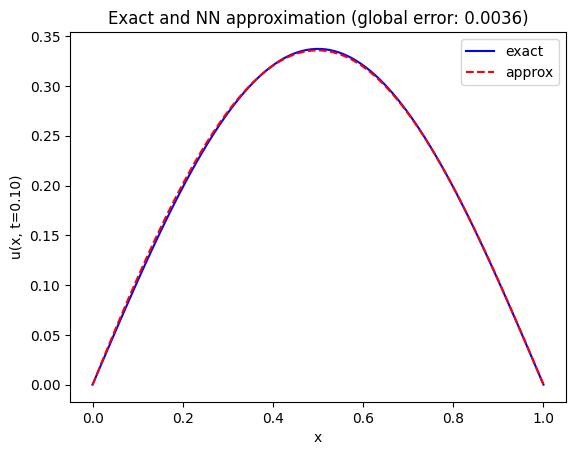

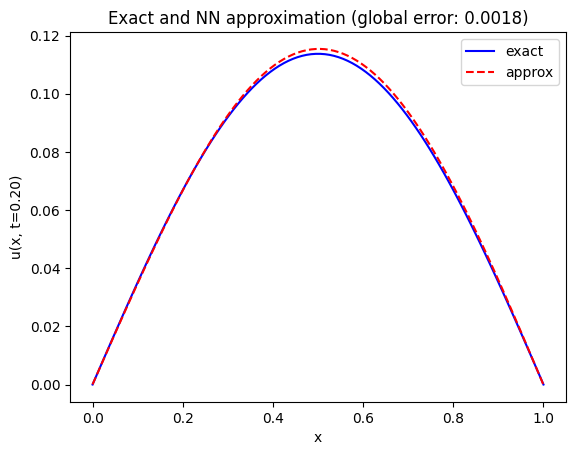

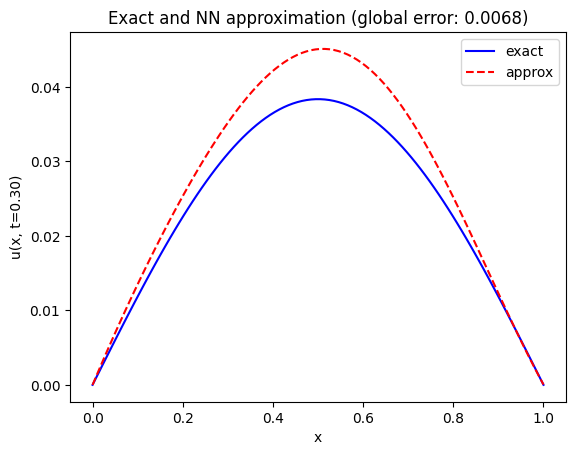

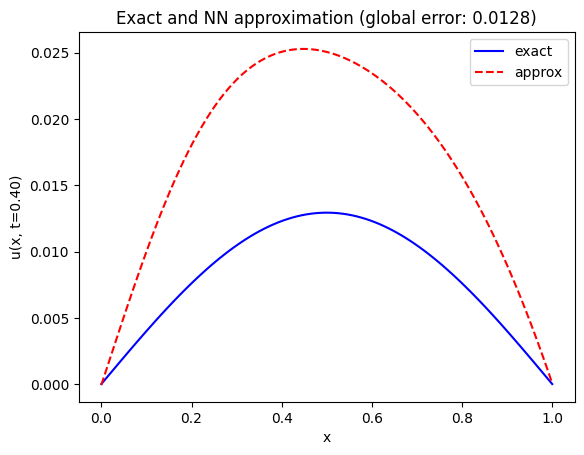

In [84]:
for dt in [0.1, 0.2, 0.3, 0.4]:
  u_approx = one_step_prediction(u_init, 0, dt)

## Time marching scheme

In certain cases we would like to see how the system evolves in time and hence we need to obtain the dependent variable at different steps in time. That is to use a time marching scheme where we start from some point at time in which we now the value of the dependent variable and then we compute solution at the next step in time. As we have seen above, we can use 0.1 or 0.2 time step and the solution will most likely remain stable, but to obtain a smooth solution we will use $\Delta t = 0.01$.

In [85]:
def time_marching_scheme(u_init, t_init, t_final, dt, show_progess=True):
  u_approx = [u_init]
  t_axis = [t_init]
  x_axis = torch.linspace(x_0, x_f, 200)
  pinn = FCN(1, len(weights), 4, 64)
  u_prev = u_approx[-1]
  t_prev = t_axis[-1]
  iterations = int( (t_final - t_init) / dt - 1 )
  for i in range(1, iterations+1):
    train_nn(pinn, u_prev.unsqueeze(-1), t_prev, dt, print_loss=False)
    u_next = model_predict(pinn, x_axis)
    t_next = t_prev + dt
    u_approx.append(u_next)
    t_axis.append(t_next)
    u_prev = u_next
    t_prev = t_next
    if i % 10 == 0:
      print(f"Iteration {i} is done")

  t_axis = torch.tensor(t_axis)
  u_approx = torch.stack(u_approx, dim=0)
  return x_axis, t_axis, u_approx

In [86]:
approximation = time_marching_scheme(u_init.squeeze(), 0, 1, 0.01)

Iteration 10 is done
Iteration 20 is done
Iteration 30 is done
Iteration 40 is done
Iteration 50 is done
Iteration 60 is done
Iteration 70 is done
Iteration 80 is done
Iteration 90 is done


In [87]:
def plot_and_compare(approx):
  x_axis, t_axis, u_approx = approx
  x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing="xy")
  plot_solution(x_grid, t_grid, u_approx, title="approximation")
  u_exact = exact_sol(x_grid, t_grid)
  abs_difference = abs(u_exact - u_approx)
  global_error = torch.max(abs_difference)
  plot_solution(x_grid, t_grid, u_exact, title="Exact")
  plot_solution(x_grid, t_grid, abs_difference,
                title=f"Absolute difference (global error: {global_error:.5f})")

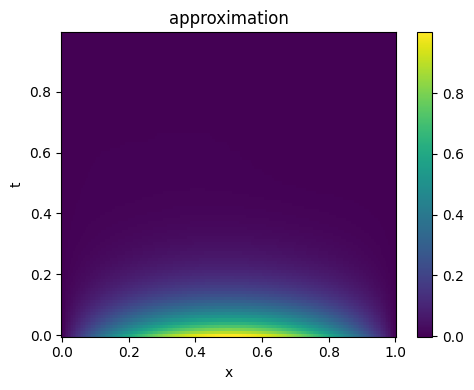

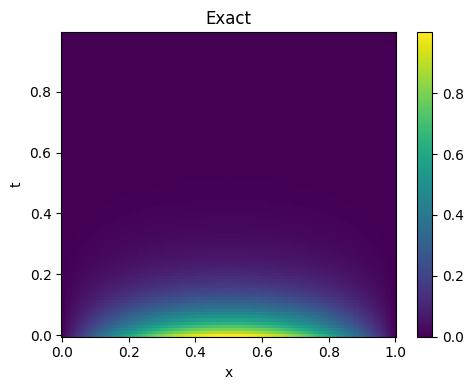

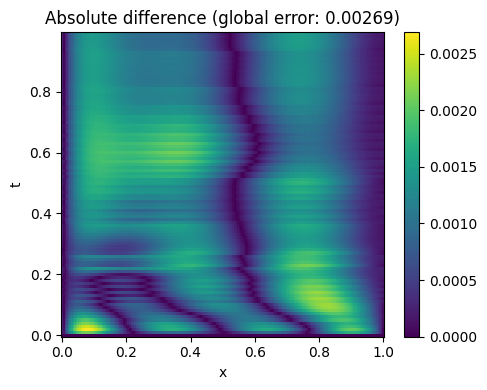

In [88]:
plot_and_compare(approximation)

# References

[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed Neural Networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045.

[2] Iserles, A. (2009). A first course in the numerical analysis of differential equations (No. 44). Cambridge university press.